In [82]:
import oracledb
import cx_Oracle
from datetime import datetime, timedelta, time, date
import numpy as np
from scipy.interpolate import splrep, splev
import csv
import pickle
from pathlib import Path
import os


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, MultiTaskLasso, MultiTaskElasticNetCV, MultiTaskElasticNet, TheilSenRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.utils import shuffle


from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import median_absolute_error


from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

#### Функция чтения данных из БД

In [2]:
def read_temperature_from_db(start_date, finish_date):

    try:
        cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
    except:
        pass
    
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    /* SELECT to_char(DATAS, 'YYYY-MM-DD'), ADVANCE_TIME,  TEMP */
    SELECT DATAS, ADVANCE_TIME,  TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = 4
          AND ADVANCE_TIME between 0 and 48
          /*AND datas >= '01-08-2022'*/
          /*AND datas between '01-08-2022' and '31-12-2022'*/
          AND datas >= :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    start_date=start_date
    )
    
    date = None
    forecast_arr = []
    f_row = [] 
    for c in cursor_nwp:
        # Нова дата - создаем новую строку данных
        if date != c[0]:
            # Если дата пройдена, присоединить строку данных f_row к массиву forecast_arr
            if date:
                forecast_arr.append(f_row) 
            # Инициализируем следующую дату и строку данных
            date = c[0]       
            f_row = [None for _ in range(50)]
            f_row[0] = c[0] # Дату c[0] записать в позицию 0
        # В позицию списка, равную заблаговременности c[1] записать температуру c[2]
        f_row[c[1] + 1] = c[2]
    # Присоединить последнюю строку данных f_row к массиву forecast_arr
    forecast_arr.append(f_row)        
    # print(*forecast_arr, sep='\n')
    conn_nwp.close()
    
    
    conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
    cursor_gts = conn_gts.cursor()
    
    cursor_gts.execute(
    """
    SELECT DATE_OBS, TEMPDB
    FROM gts.synop
    WHERE 
      /*date_obs >= '01-08-2022'*/
      /* date_obs between '01-08-2022' and '31-12-2022' */
      date_obs >= :start_date
      AND station_id = '26850'
    """,
    start_date=start_date
    )
    
    gts_rows = cursor_gts.fetchall()
    # for c in gts_rows:
    #     print(c)
    
    conn_gts.close()
    
    
    # Формирование y - значений фактической температуры, соответствующих каждой дате на 48 часов вперед
    # Поиск каждой совпадающей строки по дате и сроку 00
    start = 0
    fact_arr = []
    forecast_X = []
    td48 = timedelta(hours=48)
    for f in forecast_arr:
        date_nwp = f[0]
        # Прервать выполнение, если от даты прогноза до текущего момента 
        # прошло менее или ровно 48 часов, т.к. не будет соответствующих фактических данных
        if datetime.today() - date_nwp <= td48:
            print(datetime.today() - date_nwp)
            print(f'Прервано - для даты {date_nwp} не хватит фактических данных!')
            break
        # print('NWP Date:', date_nwp)
        # print('GTS start:', start)
        for i, g in enumerate(gts_rows[start:]):
            if g[0] == f[0]: # Строка найдена
                # print(f[0])
                start += i
                forecast_X.append(f)
                break
        # Инициализировать строку данных для фактической температуры 17 значений
        g_row = [None for _ in range(18)]
        g_row[0] = g[0]
        # print('GTS Date:', g[0])
        for j in range(17):
            gts_date = gts_rows[start + j][0]
            gts_temperature = gts_rows[start + j][1]
            td = gts_date - date_nwp
            # print('Time delta for g_row:', td, 'Temper;', gts_temperature)
            # В пределах 48 часов
            if td <= td48:
                td_hours = int(td.days * 24 + td.seconds / 3600)
                # print('td_hours', td_hours)
                cell = td_hours // 3
                # print('cell', cell)
                g_row[cell + 1] = gts_temperature
            else:
                # start += i #!!!!
                print('BREAK!!!')
                break
        fact_arr.append(g_row)
        # print(g_row)
    
    # print(*forecast_arr, sep='\n')
    # print('Fact:')
    # print(*fact_arr, sep='\n')
    
    fact_y = fact_arr
    
    
    
    # Проверка на пропущенные значения (None)
    damaged_rows = set()
    
    for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
        
        if x[0] != y[0]:
            damaged_rows.add(i)
            print('Damaged dates:', x[0], y[0])
        
        damage_x = False
        for xi in x: 
            if xi is None:
                damage_x = True
                break
        if damage_x:
            damaged_rows.add(i)
            print('x', x)
        
        damage_y = False
        for yi in y: 
            if yi is None:
                damage_y = True
                break
        if damage_y:
            damaged_rows.add(i)
            print('y', y)
    
    damaged_rows = sorted(list(damaged_rows), reverse=True)
    print(damaged_rows)
    
    # Удаление строк с пропусками
    for i in damaged_rows:
        forecast_X.pop(i)
        fact_y.pop(i)

    return forecast_X, fact_y

In [3]:
# forecast, fact = read_temperature_from_db('01-11-2022', '')

#### Функция записи датасетов в файлы CSV

In [4]:
def write_csv(forecast, fact, forecast_model, z=48, append=True):
    mode = 'at' if append else 'wt'
    # Запись прогноза
    forecast_header = ['date_term'] + [f'z_{x}' for x in range(z + 1)]
    with open(f'data/forecast_{forecast_model}.csv', mode, newline='') as f_forecast:
        forecast_writer = csv.writer(f_forecast, delimiter=';')
        if mode == 'wt':
            forecast_writer.writerow(forecast_header)
        forecast_writer.writerows(forecast)
    # Запись факта
    fact_header = ['date'] + [f't_{x % 24}' for x in range(0, z + 1, 3)]
    with open(f'data/fact.csv', mode, newline='') as f_fact:
        fact_writer = csv.writer(f_fact, delimiter=';')
        if mode == 'wt':
            fact_writer.writerow(fact_header)
        fact_writer.writerows(fact)

    # Запись файла с датой последних данных в датасетах
    date_time = forecast[-1][0]
    write_last_date_file(date_time)

#### Функция записи файла с датой последних данных в датасетах

In [5]:
def write_last_date_file(date_time):
    with open(f'data/last_date.txt', 'wt') as f:
        f.write(str(date_time))

#### Функция чтения файла с датой последних данных в датасетах

In [6]:
def read_last_date_file():
    with open(f'data/last_date.txt', 'rt') as f:
        date_time_str = f.readline()
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    return date_time

In [7]:
# read_last_date_file()

## Функция создания на диске датасетов forecast, fact

In [8]:
def create_datasets(start_date, forecast_model, z=48):
    forecast, fact = read_temperature_from_db(start_date, '')
    write_csv(forecast, fact, forecast_model, z=z, append=False)

In [9]:
# create_datasets('01-11-2022', 'gfs', z=48)

## Функция обновления датасетов новыми данными

In [10]:
def update_datasets(forecast_model, z=48):
    update_date_time = read_last_date_file() + timedelta(hours=24)
    date_str = update_date_time.strftime('%d-%m-%Y')    
    forecast, fact = read_temperature_from_db(date_str, '')
    if forecast:
        write_csv(forecast, fact, forecast_model, z=z, append=True)
    else:
        print(f'Прервано - для даты {update_date_time} не хватит фактических данных!')

In [11]:
# update_datasets('gfs', z=48)

#### Функция чтения датасетов из csv файлов

In [12]:
def read_datasets(forecast_model, train_date=None):
    if train_date:
        train_datetime_obj = datetime.strptime(train_date, '%d-%m-%Y')

    forecast = []
    with open(f'data/forecast_{forecast_model}.csv', 'rt', newline='') as f_forecast:
        forecast_reader = csv.reader(f_forecast, delimiter=';')
        forecast_header = next(forecast_reader)
        for row in forecast_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                forecast.append(r)
                continue
            break

    fact = []
    with open('data/fact.csv', 'rt', newline='') as f_fact:
        fact_reader = csv.reader(f_fact, delimiter=';')
        fact_header = next(fact_reader)
        for row in fact_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                fact.append(r)
                continue
            break

    return forecast, fact

In [13]:
# forecast, fact = read_datasets('gfs')
# print(len(forecast))
# print(len(fact))
# print(forecast[-1])
# print(fact[-1])

#### Функция подготовки X и y

In [14]:
def get_xy(forecast, fact):
    print('get_xy1')
    print(len(forecast))
    print(len(fact))
    X = np.array([xx[1:] for xx in forecast])
    y = np.array([yy[1:] for yy in fact])
    print("get_xy2")
    print(X.shape)
    print(y.shape)
    return X, y

#### Функция интерполяции строк целевых значений y

In [15]:
def interpolate_y_rows(arr, knots, degree=2):
    x = np.linspace(0, arr.shape[1], arr.shape[1])
    x_knots = np.linspace(0, arr.shape[1], knots)
    arr_new = []
    for y in arr:
        x_spl = splrep(x, y, k=degree)
        y2 = splev(x_knots, x_spl)
        arr_new.append(y2)

    
    return np.array(arr_new)


#### Функция аугментации данных

In [16]:
def augment_data(x_data, y_data, knots, degree=2):
    data_len = len(y_data)
    prior_points = np.linspace(0, data_len, data_len)
    
    xy = []
    for z in (x_data, y_data):
        z_splitted = np.hsplit(z, z.shape[1])
        #print(x_splitted)
        z_list = []
        for arr in z_splitted:
            z_spl = splrep(prior_points, arr, k=degree)
            z_points_n = np.linspace(0, data_len, knots)
            z_col_augmented = splev(z_points_n, z_spl)
            z_list.append(z_col_augmented)
        z_augmented = np.array(z_list).T
        xy.append(z_augmented)
    
    x_result, y_result = xy
    return x_result, y_result

#### Функция получения трансформеров данных

In [17]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция вычисления качества моделей

In [18]:
def quality(y_true, predicted):
    q = {}
    q["r2_score"] = r2_score(y_true, predicted) #q_max_error 
    # q[max_error] = max_error(y_true, predicted) #q_max_error 
    q["mean_absolute_error"] = mean_absolute_error(y_true, predicted) #q_mean_absolute_error
    q["mean_squared_error"] = mean_squared_error(y_true, predicted) #q_mean_squared_error 
    # q[mean_squared_log_error] = mean_squared_log_error(y_true, predicted) #q_mean_squared_log_error 
    q["median_absolute_error"] = median_absolute_error(y_true, predicted) #q_median_absolute_error 

    print(
    f'r2_score: {q["r2_score"]}',
    # f'max_error: {q[1]}',
    f'mean_absolute_error: {q["mean_absolute_error"]}',
    f'mean_squared_error: {q["mean_squared_error"]}',
    # f'mean_squared_log_error: {q[4]}',
    f'median_absolute_error: {q["median_absolute_error"]}',
    sep='\n')
    
    return q

#### Функция записи моделей в файл

In [19]:
def write_model(model_obj, forecast_model, date_str):
    with open(f'data/{forecast_model}_{date_str}.bin', 'wb') as f:
        model_bin = pickle.dump(model_obj, f, pickle.HIGHEST_PROTOCOL)

## Функция обучения моделей и записи в виде файлов

In [20]:
def train_models(forecast_model, train_date=None):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets(forecast_model, train_date)
    print('train_models')
    print(len(forecast))
    print(len(fact))
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    plt.plot(y_points_prior, y_prior[-13], 'o')
    plt.plot(y_points, y[-13])
    plt.legend()
    plt.show()
    
    
    # Аугментация данных
    X_aug, y_aug = augment_data(X_prior, y, 4000, degree=1)
    print(X_aug.shape, y_aug.shape)
    
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    # print(X_train)
    X, y = shuffle(X_aug, y_aug, random_state=42)
    
    # Условия масштабирования
    # scaler_x = 'normal-yj-st'
    # scaler_y = None

    scaler_x = 'stanard'
    scaler_y = 'normal'
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 7)
    # model = RidgeCV()
    # model = ExtraTreesRegressor(n_estimators=150, random_state=0)
    # model = RandomForestRegressor(n_estimators=150, random_state=0)
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0)
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 8, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu') # +0.42247
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=1000, alpha=0.0001, activation='relu')
    model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=1000, alpha=0.00005, activation='relu', early_stopping=True) # +0.9473 4000
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
    
    # Обучение моделей
    regr.fit(X, y)
    
    # Запись модели в файл
    date_str = datetime.strftime(forecast[-1][0], '%Y-%m-%d-%H')
    write_model(regr, forecast_model, date_str)
    
    # Оценка качества модели
    predicted = regr.predict(X)
    r2 = regr.score(X, y)
    print(r2)
    _ = quality(y, predicted)


    # regr_p= pickle.loads(pickle.dumps(regr))
    # # Оценка качества модели
    # predicted = regr_p.predict(X)
    # r2 = regr_p.score(X, y)
    # print(r2)
    # _ = quality(y, predicted)

    

In [21]:
# train_models('gfs', '21-01-2024')

#### Функция чтения очередной строки данных для прогноза из БД

In [22]:
def read_last_X(forecast_model, forecast_date):
    
    # Коды моделей
    models = {
        'gfs': 4,
        'icon': 5,
        'orv': 100,
    }

    # Запрос
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    SELECT TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = :model_id
          AND ADVANCE_TIME between 0 and 48
          AND datas = :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    start_date=forecast_date,
    model_id = models[forecast_model]          
    )

    db_data = cursor_nwp.fetchall()
    data = np.array([x[0] for x in db_data]).reshape((1, -1))
    print(data)
    # print(bool(data))
    print(data.size)

    conn_nwp.close()

    return data   

In [23]:
# read_last_X('orv', '09-01-2024')

#### Функция получения модели из файла

In [24]:
def read_model(forecast_model, model_date):

    # Получение списка моделей
    files = filter(lambda f: '.bin' in f, os.listdir('./data'))
    files = sorted(files, key=lambda f: datetime.strptime(f.split('_')[1].split('.')[0], '%Y-%m-%d-%H'), reverse=True)
    # print(files)

    # Вычисление строки даты в имени файла
    arg_datetime = datetime.strptime(model_date, '%d-%m-%Y')
    file_date = datetime.strftime(arg_datetime, '%Y-%m-%d')

    # Поиск имени файла, содержащего дату
    model_file = tuple(filter(lambda f: file_date in f, files))[0]
    print(model_file)
    
    # last_model_file = files[0]
    with open(f'data/{model_file}', 'rb') as m:
        model = pickle.load(m)

    return model
    
    

In [25]:
# read_model('gfs', '05-01-2024')

#### Функция вычисления прогноза на текущей строке данных X

In [26]:
def make_forecast(forecast_model, forecast_date):
    # Чтение последних данных X 
    X = read_last_X(forecast_model, forecast_date)

    # Получение модели из файла
    arg_datetime = datetime.strptime(forecast_date, '%d-%m-%Y')
    model_datetime = arg_datetime - timedelta(hours=48)
    model_date = datetime.strftime(model_datetime, '%d-%m-%Y')
    model = read_model(forecast_model, model_date)

    print('Model date', model_date)
        
    # Прогноз по модели
    predicted = model.predict(X)
    # print(predicted)
    return predicted

In [27]:
# make_forecast('gfs', '07-01-2024')


#### Функция прогнозирования на дату и записи прогноза в БД

In [28]:
def write_forecast_to_db(forecast_model, forecast_date):
    
    # Коды моделей
    models = {
        'gfs': 4,
        'icon': 5,
    }

    # Вычислить прогноз на дату
    temp_forecast = np.reshape(make_forecast(forecast_model, forecast_date),(-1, ))
    
    print('temp_forecast:')
    print(temp_forecast)

    # Сформировать список кортежей (строк) для записи в БД
    # (DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID, TEMP)
    datas = datetime.strptime(forecast_date, '%d-%m-%Y')
    model_id = 100
    city_id = 936
    rows_list = []
    for advance_time, temp in enumerate(temp_forecast):
        row = (temp, datas, model_id, advance_time, city_id)
        rows_list.append(row)
        
    print(rows_list) 
    
    # Определение вида операции с БД - INSERT или UPDATE
    data_on_date = read_last_X('orv', forecast_date)
    if data_on_date.size == 0:
        # Insert statement
        sql = """
        INSERT INTO nwp.GROUND_DATA (TEMP, DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID)
        VALUES (:1, :2, :3, :4, :5)
        """
    else:
        # Update statement
        sql = """
        UPDATE nwp.GROUND_DATA
        SET 
            TEMP = :1
        WHERE 
            DATAS = :2 and
            MODEL_ID = :3 and
            ADVANCE_TIME = :4 and
            CITY_ID = :5
        """
    
    # Запрос
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    cursor_nwp.executemany(sql, rows_list)
    conn_nwp.commit()

    conn_nwp.close()

    # return data   

In [29]:
# write_forecast_to_db('gfs', '23-01-2024')

#### Функция разделения на train и test с чередованием

In [30]:
def train_test_split_alternation(x, y, test_size, step=2, start=-1):
    print('train_test_split_alternation')
    print('x', x.shape)
    print('y', y.shape)
    x_test = np.empty((0, 49))
    y_test = np.empty((0, 49))
    print(x_test, x_test)
    to_del = []
    for i in range(start, -test_size * step, -step):
        try:
            # xv = x_train.pop(i)
            # yv = y_train.pop(i)
            xi = x[i]
            xi = xi[np.newaxis, ...]
            yi = y[i]
            yi = yi[np.newaxis, ...]
            x_test = np.concatenate((x_test, xi), axis=0)
            y_test = np.concatenate((y_test, yi), axis=0)
            to_del.append(i)
        except IndexError:
            break

    x_test = np.flipud(x_test)
    y_test = np.flipud(y_test)
    x_train = np.delete(x, to_del, 0)
    y_train = np.delete(y, to_del, 0)
    print('train_test_split_alternation')
    print('x_test', x_test.shape)
    print('y_test', y_test.shape)
    print('x_train', x_train.shape)
    print('y_train', y_train.shape)
    return x_train, x_test, y_train, y_test

In [31]:
def plot_lines(X_test, y_test, predicted, n=-1):
    # Графики линий
    hours = np.arange(49)
    plt.plot(hours, y_test[n], label='Факт')
    plt.plot(hours, predicted[n], label='Прогноз')
    plt.plot(hours, X_test[n, 5:], label='GFS')
    # plt.plot(hours, X_test[n], label='GFS')
    plt.legend()
    plt.show()

## Функция оценки моделей

In [107]:
def evaluate_models():

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets('gfs')
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    # plt.plot(y_points_prior, y_prior[-13], 'o')
    # plt.plot(y_points, y[-13])
    # plt.legend()
    # plt.show()

    # Разделение на тренировочный и тестовый набор Временно!
    # X_train, X_test, y_train, y_test = train_test_split(X_prior, y, test_size=35, shuffle=False, random_state=42) # Было 15
    X_train, X_test, y_train, y_test = train_test_split_alternation(X_prior, y, test_size=94, step=4, start=-1)
    X_train_q, _, y_train_q, _ = train_test_split_alternation(X_prior, y, test_size=94, step=4, start=-2)
    

    # Ассимиляция данных 0.92292
    X_train = np.hstack((y_train[:, 0:5], X_train))
    X_test = np.hstack((y_test[:, 0:5], X_test))
    
    

    # Аугментация данных Временно!
    X_train, y_train = augment_data(X_train, y_train, 4000, degree=1)
    print(X_train.shape, y_train.shape)
    
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False, random_state=42)
    # Перемешивание
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    print('X_test.shape', X_test.shape)
    
    # Условия масштабирования 0.864795
    # scaler_x = 'standard' #'normal' #'normal-yj-st' #None #'normal-yj-st'
    # scaler_y = 'normal' #'normal' #'normal-yj-st' #None #'standard' # None

    # 0.906089
    # scaler_x = 'normal-yj-st'
    # scaler_y = None

    # 0.95876
    # scaler_x = None
    # scaler_y = None

    # # 0.85912
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj-st'

    # # 0.8574014
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal'
    
    # # 0.86674
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj'

    # # 0.8508759
    # scaler_x = 'standard'
    # scaler_y = 'standard'
    
    # scaler_x = 'standard'
    # scaler_y = None

    # scaler_x = 'normal'
    # scaler_y = 'normal'

    # scaler_x = 'normal'
    # scaler_y = None

    # scaler_x = 'normal-yj'
    # scaler_y = None

    # 0.876117
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'standard'

    # scaler_x = 'normal-yj'
    # scaler_y = 'normal-yj'
    
    # 0.95847
    # scaler_x = 'robust'
    # scaler_y = 'robust'
    
    # scaler_x = 'uniform'
    # scaler_y = None

    # 0.95928
    # scaler_x = 'robust'
    # scaler_y = 'normal-yj'
    
    # 0.95748
    # scaler_x = 'robust'
    # scaler_y = 'standard'

    #0.961235 !!! 0.96353 RidgeCV
    scaler_x = 'robust'
    scaler_y = None


    # 'normal''normal' 0.7364
    # None None 0.58707
    # 'normal-yj-st' 'normal-yj-st' 0.778169
    # 'normal' 'normal'0.73643
    # 'standard' 'standard' 0.788689
    # 'standard' 'normal'0.753527
    # 'normal' 'standard' 0.130696
    # 'minmax' 'minmax' 0.56305
    # 'maxabs' 'maxabs' -35.48
    # test_size=15
    # 'normal-yj-st' none 0.71757
    # 'standard' None 0.72584
    # 'standard' 'standard' 0.7692
    # 'normal-yj-st' 'normal-yj-st' 0.74478
    # 'normal-yj-st' 'standard' 0.76224
    # 'normal' 'standard' 0.0092
    # 'standard' 'normal' 0.771224
    
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 5)#-3.65  0.75466 4000
    
    # model = RidgeCV() #0.963531 !!!
    # model = KernelRidge(alpha=0.1, kernel='poly', degree=1, coef0=2)  #0.966857!!!    
    
    # model = ExtraTreesRegressor(n_estimators=150, random_state=0) #-6.05 +0.8307 3000
    # model = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0) #TPOT !!!! 0.9529
    
    # model = RandomForestRegressor(n_estimators=150, random_state=0) #-4.55
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0) #-2.25
   
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 8, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu') # +0.42247 !!! +0.84355 4000    
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True) # +0.9473 4000 !!!! 0.9427 12000

    # model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)) #0.95861
    # model = MultiOutputRegressor(KernelRidge(alpha=0.1, kernel='poly', degree=1, coef0=2)) #0.966857
    # model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors = 24)) #0.948019
    # model = MultiOutputRegressor(ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0)) #0.9632

    # model = MultiTaskLasso(alpha=0.01, random_state=0, max_iter=1000, selection='cyclic', tol=1e-5) #0.967350 0.01!!!!! 
    # model = MultiTaskElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, max_iter=1000, tol=0.0001, n_jobs=None, random_state=0, selection='cyclic') #0.95941
    # model = MultiTaskElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic') #0.967350 !!!!!
    # model = RANSACRegressor(MultiTaskLasso(alpha=0.01, random_state=0, max_iter=1000, selection='cyclic', tol=1e-4), 
    #                         min_samples=0.2, residual_threshold=None, is_data_valid=None, is_model_valid=None,
    #                         max_trials=1000, max_skips=np.inf, stop_n_inliers=np.inf, stop_score=0.97, stop_probability=0.99, loss='squared_error', random_state=0)
    
    # model = MultiOutputRegressor( 
    #     TheilSenRegressor(max_subpopulation=10000.0, n_subsamples=None, max_iter=300, tol=0.001, random_state=0, verbose=True) #0.9519930
    # )

    # model = PLSRegression(n_components=13, tol=1e-06, max_iter=1000) #0.966911
    model = PLSCanonical(n_components=12, algorithm='svd') #0.94961
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    # decomposition = PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized') #!!
    # decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    # decomposition = RBFSampler(gamma=0.9)
    # decomposition = FastICA(tol=0.5)

    decomposition = []
    # decomposition.append(PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized'))
    # decomposition.append(FastICA(tol=0.5))
    # decomposition.append(RBFSampler(gamma=0.9))
    # decomposition.append(KernelPCA(n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1))
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, *decomposition, regressor) if transformer_x else \
           make_pipeline(*decomposition, regressor) if decomposition else \
           regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
    # regr = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0) #TPOT !!!! 0.9529
    
    
    # Обучение моделей
    regr.fit(X_train, y_train)
    
    # Запись модели в файл
    
    # Оценка качества модели
    predicted = regr.predict(X_test)
    # r2 = regr.score(X_test, y_test)
    # print(r2)
    print('--ТЕСТОВАЯ ВЫБОРКА:--')
    _ = quality(y_test, predicted)
    print('--ИСХОДНАЯ ВЫБОРКА:--')
    _ = quality(X_train_q, y_train_q)
    print('--ИСХОДНЫЙ НАБОР:--')
    _ = quality(X_prior, y)
    print('--ТРЕНИРОВОЧНЫЙ НАБОР:--')
    _ = quality(X_train[:, 5:], y_train)

    return X_test, y_test, predicted

In [108]:
X_test, y_test, predicted = evaluate_models()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

get_xy1
373
373
get_xy2
(373, 49)
(373, 17)
train_test_split_alternation
x (373, 49)
y (373, 49)
[] []
train_test_split_alternation
x_test (94, 49)
y_test (94, 49)
x_train (279, 49)
y_train (279, 49)
train_test_split_alternation
x (373, 49)
y (373, 49)
[] []
train_test_split_alternation
x_test (93, 49)
y_test (93, 49)
x_train (280, 49)
y_train (280, 49)
(4000, 54) (4000, 49)
X_test.shape (94, 54)
--ТЕСТОВАЯ ВЫБОРКА:--
r2_score: 0.949610440979425
mean_absolute_error: 1.4474678408766863
mean_squared_error: 3.843495140800521
median_absolute_error: 1.1079580136040257
--ИСХОДНАЯ ВЫБОРКА:--
r2_score: 0.948076119600379
mean_absolute_error: 1.55232653138863
mean_squared_error: 4.492136610147412
median_absolute_error: 1.1781482798340162
--ИСХОДНЫЙ НАБОР:--
r2_score: 0.949007253891676
mean_absolute_error: 1.548566576016452
mean_squared_error: 4.499849497749667
median_absolute_error: 1.1624202472804637
--ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.9601428002840064
mean_absolute_error: 1.378668431416358
me

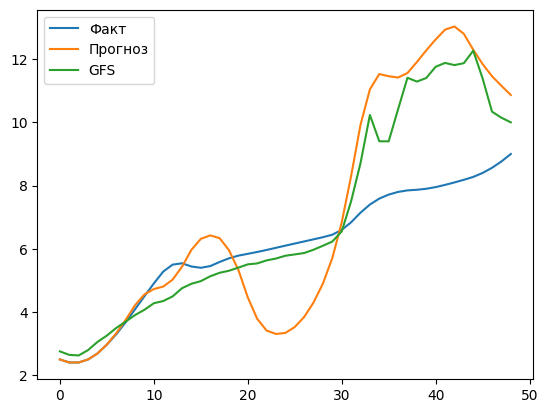

In [34]:
plot_lines(X_test, y_test, predicted, n=-24)

In [35]:
a1 = np.array

In [36]:
#### Обучение по последней точке

In [37]:
def evaluate_models():

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets('gfs')
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    # plt.plot(y_points_prior, y_prior[-13], 'o')
    # plt.plot(y_points, y[-13])
    # plt.legend()
    # plt.show()

    # Разделение на тренировочный и тестовый набор Временно!
    # X_train, X_test, y_train, y_test = train_test_split(X_prior, y, test_size=35, shuffle=False, random_state=42) # Было 15
    X_train, X_test, y_train, y_test = train_test_split_alternation(X_prior, y, test_size=135, step=5)
    

    # Ассимиляция данных 0.92292
    X_train = np.hstack((y_train[:, 0:5], X_train))
    X_test = np.hstack((y_test[:, 0:5], X_test))
    
    

    # Аугментация данных Временно!
    X_train, y_train = augment_data(X_train, y_train, 4000, degree=1) #4000 745
    print(X_train.shape, y_train.shape)
    
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False, random_state=42)
    # Перемешивание
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    y_train = y_train[:, -1]
    y_test = y_test[:, -1]
    
    print('X_test.shape', X_test.shape)

    from tpot import TPOTRegressor
    
    # # TPOT
    # tpot = TPOTRegressor(generations=6, population_size=150, verbosity=3, random_state=42, n_jobs=4, memory='auto', scoring='r2')
    # tpot.fit(X_train, y_train)
    # print(tpot.score(X_test, y_test))
    # tpot.export('tpot_gfs_coef_pipeline_49.py')


    


    
    
    # Условия масштабирования 0.864795
    # scaler_x = 'standard' #'normal' #'normal-yj-st' #None #'normal-yj-st'
    # scaler_y = 'normal' #'normal' #'normal-yj-st' #None #'standard' # None

    # 0.906089
    scaler_x = 'normal-yj-st'
    scaler_y = None

    # # 0.85912
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj-st'

    # # 0.8574014
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal'
    
    # # 0.86674
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj'

    # # 0.8508759
    # scaler_x = 'standard'
    # scaler_y = 'standard'

    # 0.876117
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'standard'
    

    # 'normal''normal' 0.7364
    # None None 0.58707
    # 'normal-yj-st' 'normal-yj-st' 0.778169
    # 'normal' 'normal'0.73643
    # 'standard' 'standard' 0.788689
    # 'standard' 'normal'0.753527
    # 'normal' 'standard' 0.130696
    # 'minmax' 'minmax' 0.56305
    # 'maxabs' 'maxabs' -35.48
    # test_size=15
    # 'normal-yj-st' none 0.71757
    # 'standard' None 0.72584
    # 'standard' 'standard' 0.7692
    # 'normal-yj-st' 'normal-yj-st' 0.74478
    # 'normal-yj-st' 'standard' 0.76224
    # 'normal' 'standard' 0.0092
    # 'standard' 'normal' 0.771224
    
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 5)#-3.65  0.75466 4000
    # model = RidgeCV() #-2.20 +0.78115 4000
    # model = ExtraTreesRegressor(n_estimators=150, random_state=0) #-6.05 +0.8307 3000
    model = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=100) #TPOT
    # model = RandomForestRegressor(n_estimators=150, random_state=0) #-4.55
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0) #-2.25

    
   
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 8, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu') # +0.42247 !!! +0.84355 4000    
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True) # +0.9473 4000 !!!! 0.9427 12000

    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    # decomposition = PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized') #!!
    decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor

    regr = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=100) #TPOT


    # # Average CV score on the training set was: 0.9817920529729014
    # regr = make_pipeline(
    # StackingEstimator(estimator=AdaBoostRegressor(learning_rate=0.1, loss="exponential", n_estimators=100)),
    # PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    # RidgeCV()
    # )
    # # Fix random state for all the steps in exported pipeline
    # set_param_recursive(regr.steps, 'random_state', 42)


    
    # Обучение моделей
    regr.fit(X_train, y_train)
    
    # Запись модели в файл
    
    # Оценка качества модели
    predicted = regr.predict(X_test)
    # r2 = regr.score(X_test, y_test)
    # print(r2)
    _ = quality(y_test, predicted)

    # Оценка качества исходного прогноза
    _ = quality(X_train[:, -1], y_train)
    # _ = quality(X_train, y_train)


    

    return X_test, y_test, predicted

In [38]:
# X_test, y_test, predicted = evaluate_models()
# print('X_test', X_test.shape)
# print('y_test', y_test.shape)